In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import gensim
import string
from collections import OrderedDict
from gensim import corpora, models, similarities
import seaborn as sns
import pyLDAvis.gensim
import matplotlib.pyplot as plt


class LDAHelper:
    """
    Current LDAHelper implementation within pipeline
    """
    def __init__(self):
        self.version = 0
        self.stopwords = [
            'RT',
            'rt'
        ] + stopwords.words('english') + list(string.punctuation)

    def clean_up(self, word):
        """
        Clean up punctuation.
        Lower case string.
        :param word: full length tweet
        :return: Cleaned up tweet
        """
        return word.translate(None, string.punctuation)

    def lemmatize_stemming(self, word_without_punctuation):
        """
        Lemmatize and stemming a word
        :param word_without_punctuation:
        :return: resulting word
        """
        stemmer = SnowballStemmer('english')
        return stemmer.stem(WordNetLemmatizer().lemmatize(word_without_punctuation, pos='v'))
    
    def valid(self, word):
        """
        Verify the validity of a word.
        :param word: word in a tweet
        :return: True if the word passes a set of rules. To be formalized later
        """
        return word not in self.stopwords and word[:1] != '@' and word[:4] != 'http'

    def preprocess(self, tweet):
        """
        Applying lemmatization and stemming to any word that is not part of
        our stopwords
        :param tweet: Full tweet
        :return: Array of processed words
        """
        return [self.lemmatize_stemming(word)
                for word in gensim.utils.simple_preprocess(tweet, min_len=3)
                if self.valid(word)]
    
    def preprocess_without_LS(self, tweet):
        """
        Pre processing without lemmatization and stemming to test results 
        from this paper http://www.cs.cornell.edu/~xanda/winlp2017.pdf?fbclid=IwAR1v1kud8O551DJysvtuU2UC0Ra-oAAPLban_ZiKfyvN58_aWCjZUdjMQeM
        :param tweet: Full tweet
        :return: Array of processed words
        """
        return [word
                for word in gensim.utils.simple_preprocess(tweet, min_len=3)
                if self.valid(word)]
    

In [2]:
l = LDAHelper()
l.preprocess('So good to see that Republicans will be winning the Great State of Alabama Senate Seat back, now that lightweight Senator @DougJones cast a partisan vote for the Impeachment Hoax. Thought his boss, Cryin’ Chuck, would have forced him to vote against the Hoax. A Do Nothing Stiff!')

[u'good',
 u'see',
 u'republican',
 u'win',
 u'great',
 u'state',
 u'alabama',
 u'senat',
 u'seat',
 u'back',
 u'lightweight',
 u'senat',
 u'dougjon',
 u'cast',
 u'partisan',
 u'vote',
 u'impeach',
 u'hoax',
 u'think',
 u'boss',
 u'cryin',
 u'chuck',
 u'would',
 u'forc',
 u'vote',
 u'hoax',
 u'noth',
 u'stiff']

### PROOF OF CONCEPT
Experiment is ran on 1.6 million english tweets from users across the world. No specific topics are expected

In [3]:
# Load dataset
dataset = './training_set.csv'
tweets = pd.read_csv(dataset, encoding='latin1')
tweets = tweets['Tweet']
tweets.head(5)

IOError: File ./training_set.csv does not exist

In [ ]:
# Preprocessing all tweets
# 1. Separating a tweet into array of words
# 2. Lemmatization and stemming
# 3. Removing all stopwords, @Username, links and words of length less than 2
corpus = []
for tweet in tweets:
    corpus.append(l.preprocess_without_LS(tweet))

corpus[0:10]

In [ ]:
# 1. Transforming corpus into Dictionary (mapping of normalized words to integer ID)
# 2. Transforming each tweet into bag of words (Mapping of word to its occurence in tweet)
# 3. TDIDF (term frequency-inverse document frequency) Model created
dictionary = corpora.Dictionary(corpus)
bow_corpus = [dictionary.doc2bow(text) for text in corpus]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [ ]:
# LDA Model created
total_topics = 5
lda = models.LdaModel(bow_corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[bow_corpus]

In [ ]:
lda.show_topics(total_topics, 5)

In [ ]:
# Save our model - Eventually to EC2 Instance
from gensim.test.utils import datapath

temp_file = datapath("general_tweets_NO_LS_model")
lda.save(temp_file)

In [ ]:
# Show mapping of words to topics
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

In [ ]:
g=sns.clustermap(df_lda.corr(), 
                 center=0, 
                 standard_scale=1, 
                 cmap="RdBu", 
                 metric='cosine', 
                 linewidths=.75, 
                 figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

### EXPERIMENT ON HISTORICAL DONALD TRUMP TWEETS

In [5]:
dataset = './donald_trump_tweets.csv'
tweets = pd.read_csv(dataset, encoding='latin1')
tweets.head(5)

,text
0,Thank you @BlueAngels and @AFThunderbirds! #Am...
1,RT @TomFitton: BREAKING: Emails show Obama FBI...
2,RT @nedryun: A fifth to half of all coronaviru...
3,RT @GreggJarrett: Newly Declassified Documents...
4,RT @GreggJarrett: Newly Revealed Docs Support ...


In [6]:
corpus_DT = []
for tweet in tweets['text']:
    corpus_DT.append(l.preprocess_without_LS(tweet))

corpus_DT[0:10]

[[u'thank',
  u'blueangels',
  u'afthunderbirds',
  u'americastrong',
  u'ozyfjbt',
  u'vokysmd'],
 [u'tomfitton',
  u'breaking',
  u'emails',
  u'show',
  u'obama',
  u'fbi',
  u'get',
  u'genflynn',
  u'also',
  u'knew',
  u'mccain',
  u'leaked',
  u'anti',
  u'realdonaldtrump',
  u'dossier',
  u'judicia\xe2'],
 [u'nedryun',
  u'fifth',
  u'half',
  u'coronavirus',
  u'deaths',
  u'nursing',
  u'homes',
  u'clfe'],
 [u'greggjarrett',
  u'newly',
  u'declassified',
  u'documents',
  u'show',
  u'john',
  u'kerry\xe2',
  u'state',
  u'department',
  u'spread',
  u'russia',
  u'collusion',
  u'narrative',
  u'glrdt'],
 [u'greggjarrett',
  u'newly',
  u'revealed',
  u'docs',
  u'support',
  u'flynn\xe2',
  u'innocence',
  u'case',
  u'tossed',
  u'znfzz',
  u'vuy'],
 [u'love',
  u'diamond',
  u'amp',
  u'silk',
  u'millions',
  u'people',
  u'rbx',
  u'bmfiwh'],
 [u'whitehouse',
  u'days',
  u'ago',
  u'business',
  u'leaders',
  u'joined',
  u'president',
  u'realdonaldtrump',
  u'rose'

In [7]:
dictionary = corpora.Dictionary(corpus_DT)
bow_corpus = [dictionary.doc2bow(text) for text in corpus_DT]
#tfidf = models.TfidfModel(bow_corpus)
#corpus_tfidf = tfidf[bow_corpus]

In [8]:
total_topics = 5
lda = models.LdaModel(bow_corpus, 
                      id2word=dictionary, 
                      num_topics=total_topics)
corpus_lda = lda[corpus_tfidf]

In [9]:
lda.show_topics(total_topics,10)

[(0,
  u'0.039*"trump" + 0.035*"realdonaldtrump" + 0.031*"great" + 0.030*"barackobama" + 0.024*"thanks" + 0.015*"donald" + 0.012*"america" + 0.011*"thank" + 0.009*"new" + 0.008*"com"'),
 (1,
  u'0.021*"realdonaldtrump" + 0.014*"obama" + 0.009*"think" + 0.009*"would" + 0.009*"like" + 0.009*"apprentice" + 0.008*"trump" + 0.007*"president" + 0.007*"amp" + 0.006*"china"'),
 (2,
  u'0.010*"happy" + 0.009*"tonight" + 0.009*"iran" + 0.009*"thanks" + 0.008*"realdonaldtrump" + 0.007*"art" + 0.006*"interview" + 0.006*"discussing" + 0.006*"obama" + 0.006*"iraq"'),
 (3,
  u'0.029*"cont" + 0.009*"jobs" + 0.009*"great" + 0.009*"tower" + 0.009*"bit" + 0.008*"amp" + 0.006*"miss" + 0.006*"timetogettough" + 0.006*"tune" + 0.005*"country"'),
 (4,
  u'0.010*"great" + 0.010*"amp" + 0.009*"new" + 0.007*"hotel" + 0.006*"get" + 0.005*"people" + 0.005*"must" + 0.005*"scotland" + 0.005*"mittromney" + 0.004*"work"')]

In [10]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

,amazing,america,amp,apprentice,art,attack,back,barackobama,best,birthday,...,unemployment,via,waste,wind,work,world,would,yankees,yes,york
0,0.004333,0.011696,0.000000,0.000000,0.000000,0.000000,0.000000,0.029854,0.005029,0.000000,...,0.000000,0.007426,0.000000,0.000000,0.0000,0.004197,0.000000,0.000000,0.00000,0.000000
1,0.000000,0.000000,0.006518,0.008522,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.008745,0.000000,0.00000,0.000000
2,0.000000,0.000000,0.003940,0.000000,0.007329,0.004582,0.000000,0.000000,0.000000,0.004541,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000
3,0.000000,0.000000,0.007979,0.000000,0.000000,0.000000,0.000000,0.000000,0.003229,0.000000,...,0.004012,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.003603,0.00000,0.000000
4,0.000000,0.000000,0.009691,0.000000,0.000000,0.000000,0.003179,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.003037,0.004242,0.0045,0.000000,0.000000,0.000000,0.00288,0.004078


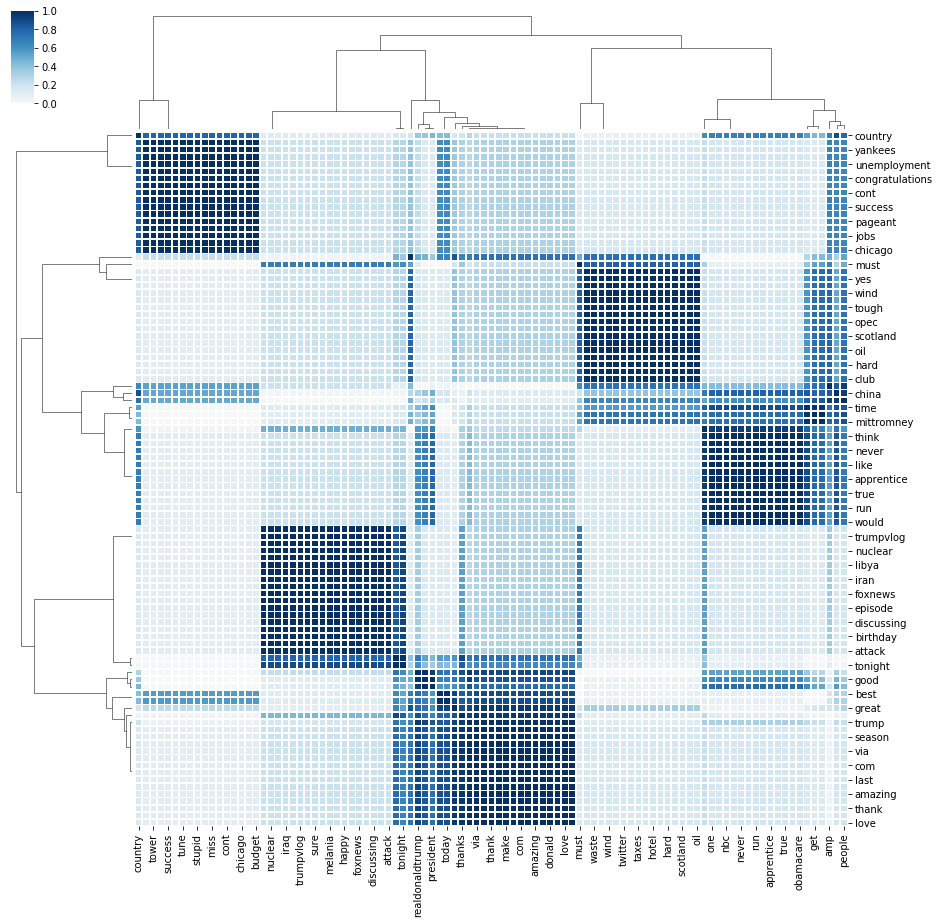

In [11]:
g=sns.clustermap(df_lda.corr(), 
                 center=0, 
                 standard_scale=1, 
                 cmap="RdBu", 
                 metric='cosine', 
                 linewidths=.75, 
                 figsize=(15, 15))

plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [26]:
# Let's try to predict one tweet for DT
unseen_tweets = [
'So good to see that Republicans will be winning the Great State of Alabama Senate Seat back, now that lightweight Senator @DougJones cast a partisan vote for the Impeachment Hoax. Thought his boss, Cryin’ Chuck, would have forced him to vote against the Hoax. A Do Nothing Stiff!',
'Tune in the apprentice tonight and see which the celebrity wins our TV show!',
'MAKE AMERICA GREAT AGAIN!' ]
corpus_exp = [l.preprocess_without_LS(tweet) for tweet in unseen_tweets]
bow_corpus = [dictionary.doc2bow(text) for text in corpus_exp]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
unseen_corpus_lda = lda[corpus_tfidf[0]]
unseen_corpus_lda

[(0, 0.03669953),
 (1, 0.45451155),
 (2, 0.092942655),
 (3, 0.035580307),
 (4, 0.38026598)]

In [25]:
from gensim.test.utils import datapath

#temp_file = datapath("./LDAmodel_realDonaldTrump")
lda.save("./LDAmodel_realDonaldTrump")
dictionary.save("./dictionary_realDonaldTrump")

In [16]:
ok = LdaModel.load("./LDAmodel_realDonaldTrump.id2word")

NameError: name 'LdaModel' is not defined